## Import Libraries

In [1]:
#Libraries
!pip install -q category_encoders
!pip install -q tldextract

import os
import re
import math
import glob
from pathlib import Path
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()

import tldextract
from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
from sklearn.decomposition import PCA
from sklearn.utils import resample
from scipy.sparse import hstack, csr_matrix



from transformers import AutoTokenizer, AutoModel
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using device:", device)



#from google.colab import drive
#drive.mount('/content/drive')


Using device: cpu


## Preprocessing

In [2]:
# Dataset Path
path = "phishing_site_urls.csv"

# Load dataset
df = pd.read_csv(path)

# View
print(df.shape)
print(df.head())

print(' ')
print('Duplicates')
print(df.duplicated().sum())

df.drop_duplicates(inplace=True)
print(' ')
print('Duplicates after drop')
print(df.duplicated().sum())

(549346, 2)
                                                 URL Label
0  nobell.it/70ffb52d079109dca5664cce6f317373782/...   bad
1  www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...   bad
2  serviciosbys.com/paypal.cgi.bin.get-into.herf....   bad
3  mail.printakid.com/www.online.americanexpress....   bad
4  thewhiskeydregs.com/wp-content/themes/widescre...   bad
 
Duplicates
42150
 
Duplicates after drop
0


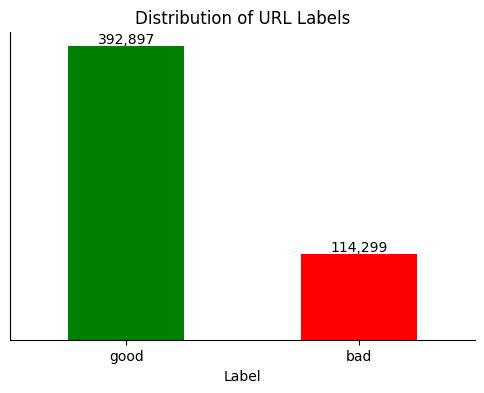

In [3]:
# Count label
label_counts = df['Label'].value_counts()

plt.figure(figsize=(6,4))
ax = label_counts.plot(kind='bar', color=['green','red'])

# Add title and labels
plt.title("Distribution of URL Labels")
plt.xlabel("Label")
plt.ylabel("")
ax.set_yticks([])  # Remove y-axis ticks

# Add counts on top of bars
for p in ax.patches:
    height = int(p.get_height())
    ax.annotate(f'{height:,}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.xticks(rotation=0)

# Remove top and right spines (box)
sns.despine(ax=ax)

plt.show()


In [4]:
# Separate classes
df_good = df[df['Label'] == 'good']
df_bad  = df[df['Label'] == 'bad']

# Target size = bad_count + 1000
target_good_size = len(df_bad) + 1000

# Downsample good
df_good_down = resample(
    df_good,
    replace=False,       # no replacement
    n_samples=target_good_size,
    random_state=42
)

# Combine balanced dataset
df_balanced = pd.concat([df_good_down, df_bad]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Original counts:")
print(df['Label'].value_counts())
print("\nBalanced counts:")
print(df_balanced['Label'].value_counts())


Original counts:
Label
good    392897
bad     114299
Name: count, dtype: int64

Balanced counts:
Label
good    115299
bad     114299
Name: count, dtype: int64


In [5]:
dfb = df_balanced.copy()

# Map labels: bad=1 (phishing), good=0 (legit)
dfb['label_bin'] = dfb['Label'].str.lower().map({'bad': 1, 'good': 0})
dfb.head()

,URL,Label,label_bin
0,encyclopedia2.thefreedictionary.com/Royal+Society,good,0
1,www.fullswingmarketing.com/wp-includes/images/...,bad,1
2,www.saudevitalsuplementos.com/media/system/ima...,bad,1
3,linkedin.com/pub/james-e-tate/21/275/8a0,good,0
4,8simplerules.tvheaven.com/presskit.html,good,0


In [6]:
def clean_url(url: str) -> str:
    """
    Normalize and clean a URL string.
    - Lowercase
    - Remove http://, https://
    - Remove leading www.
    - Remove trailing /
    - Strip query params (?...) and fragments (#...)
    """
    if pd.isna(url):
        return ""

    url = url.lower().strip()

    # Remove protocol
    url = re.sub(r'^https?:\/\/', '', url)

    # Remove leading www.
    url = re.sub(r'^www\.', '', url)

    # Remove query params and fragments
    url = re.sub(r'[\?#].*', '', url)

    # Remove trailing slash
    url = url.rstrip('/')

    return url

# Apply to your dataframe
dfb['url_clean'] = dfb['URL'].progress_apply(clean_url)
dfb[['URL', 'url_clean']].head(10)


  0%|          | 0/229598 [00:00<?, ?it/s]

,URL,url_clean
0,encyclopedia2.thefreedictionary.com/Royal+Society,encyclopedia2.thefreedictionary.com/royal+society
1,www.fullswingmarketing.com/wp-includes/images/...,fullswingmarketing.com/wp-includes/images/crys...
2,www.saudevitalsuplementos.com/media/system/ima...,saudevitalsuplementos.com/media/system/images/...
3,linkedin.com/pub/james-e-tate/21/275/8a0,linkedin.com/pub/james-e-tate/21/275/8a0
4,8simplerules.tvheaven.com/presskit.html,8simplerules.tvheaven.com/presskit.html
5,choogo.net/1flkmj9s,choogo.net/1flkmj9s
6,donations.ebay.com/charity/charity.jsp?NP_ID=5281,donations.ebay.com/charity/charity.jsp
7,ricardoeletro.com.br.promo70off.com/produtos/1...,ricardoeletro.com.br.promo70off.com/produtos/1...
8,preview.createsend1.com/t/ViewEmail/t/881D9787...,preview.createsend1.com/t/viewemail/t/881d9787...
9,anmaufla.podomatic.com/,anmaufla.podomatic.com


## Heuristic Features

In [7]:
# List of sensitive words commonly found in phishing URLs
SENSITIVE_WORDS = [
    'confirm', 'account', 'banking', 'secure', 'ebyisapi', 'webscr', 'signin',
    'mail', 'install', 'toolbar', 'backup', 'paypal', 'password', 'username'
]

# Common URL shortening services
URL_SHORTENERS = [
    'bit.ly', 'tinyurl.com', 'goo.gl', 'ow.ly', 't.co', 'is.gd', 'buff.ly'
]

def extract_url_features(url: str):
    """
    Extract 12 phishing-related features from a URL.
    Returns a dict with feature names and 0/1 values.
    """
    url = url.lower()
    features = {}

    # Parse URL
    parsed = urlparse(url)
    hostname = parsed.hostname or ''
    path = parsed.path or ''

    #Presence of IP address
    features['has_ip'] = int(re.match(r'(\d{1,3}\.){3}\d{1,3}$', hostname) is not None)

    #Presence of @ symbol
    features['has_at'] = int('@' in url)

    #Number of dots in hostname > 3
    features['many_dots'] = int(hostname.count('.') > 3)

    #Prefix/suffix with '-' in domain
    ext = tldextract.extract(url)
    features['dash_in_domain'] = int('-' in ext.domain)

    #URL redirection (// in path after domain)
    # '//' occurs in netloc normally; we check for additional in path
    features['url_redirection'] = int('//' in path)

    # URL shortening services
    features['shortened'] = int(any(short in hostname for short in URL_SHORTENERS))

    #Length of hostname > 25
    features['long_hostname'] = int(len(hostname) > 25)

    #Presence of sensitive words
    features['sensitive_words'] = int(any(word in url for word in SENSITIVE_WORDS))

    #Number of slashes in URL > 5
    features['many_slashes'] = int(url.count('/') > 5)

    #Presence of Unicode in URL
    features['has_unicode'] = int(any(ord(c) > 127 for c in url))

    return features


dfb['url_features'] = dfb['URL'].progress_apply(extract_url_features)

# Convert dict column to separate columns
features_df = pd.json_normalize(dfb['url_features'])
dfb = pd.concat([dfb, features_df], axis=1)
dfb.drop(columns=['url_features'], inplace=True)
dfb.nunique()

  0%|          | 0/229598 [00:00<?, ?it/s]

unable to cache publicsuffix.org-tlds.{'urls': ('https://publicsuffix.org/list/public_suffix_list.dat', 'https://raw.githubusercontent.com/publicsuffix/list/master/public_suffix_list.dat'), 'fallback_to_snapshot': True} in c:\ProgramData\anaconda3\Lib\site-packages\tldextract\.suffix_cache/publicsuffix.org-tlds\de84b5ca2167d4c83e38fb162f2e8738.tldextract.json. This could refresh the Public Suffix List over HTTP every app startup. Construct your `TLDExtract` with a writable `cache_dir` or set `cache_dir=False` to silence this warning. [WinError 5] Access is denied: 'c:\\ProgramData\\anaconda3\\Lib\\site-packages\\tldextract\\.suffix_cache'


URL                229598
Label                   2
label_bin               2
url_clean          200944
has_ip                  2
has_at                  2
many_dots               2
dash_in_domain          2
url_redirection         2
shortened               2
long_hostname           2
sensitive_words         2
many_slashes            2
has_unicode             2
dtype: int64

Detected binary features: ['label_bin', 'has_ip', 'has_at', 'many_dots', 'dash_in_domain', 'url_redirection', 'shortened', 'long_hostname', 'sensitive_words', 'many_slashes', 'has_unicode']


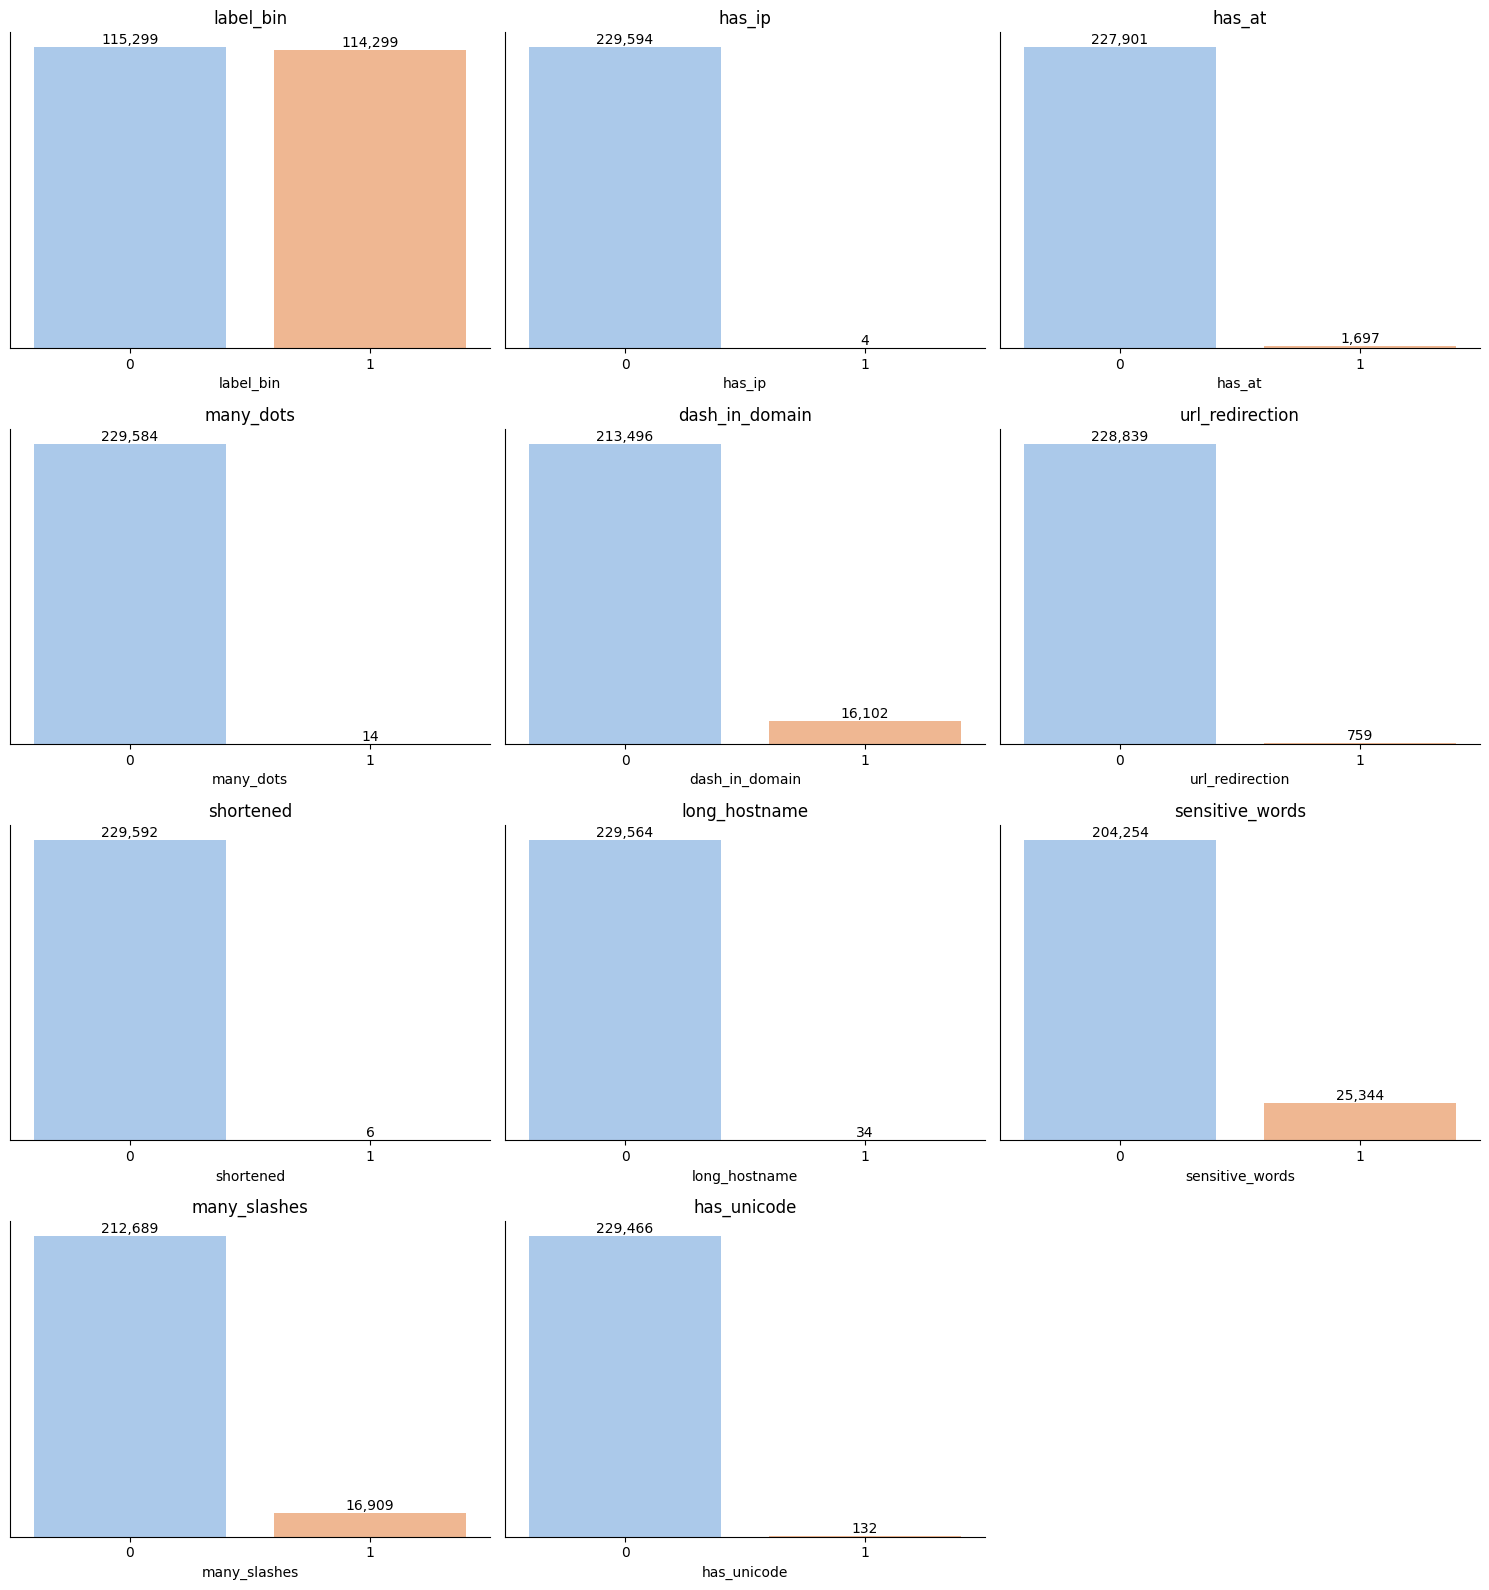

In [8]:
# Automatically detect binary columns (numeric columns with only 0 and 1)
binary_features = [col for col in dfb.select_dtypes(include=['int64', 'float64']).columns
                   if dfb[col].dropna().isin([0,1]).all()]

print("Detected binary features:", binary_features)

# Dynamically set rows and cols based on number of binary features
total_features = len(binary_features)
cols = 3
rows = math.ceil(total_features / cols)

plt.figure(figsize=(5*cols, 4*rows))

for i, col in enumerate(binary_features, 1):
    plt.subplot(rows, cols, i)
    ax = sns.countplot(x=dfb[col], palette="pastel")
    plt.title(col)

    # Remove y-axis
    ax.set_ylabel('')
    ax.set_yticks([])

    # Remove top and right spines
    sns.despine(ax=ax)

    # Add count labels with commas
    for p in ax.patches:
        height = int(p.get_height())
        ax.annotate(f'{height:,}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [9]:
# List of features to drop
# Reason: These features are almost constant (very few 1s), so they provide little to no predictive value
drop_features = ['has_ip',       # Only 4 URLs have IP ; too rare
                 'many_dots',    # Almost all URLs are 0 ; low variance
                 'shortened',    # Extremely rare ; minimal signal
                 'long_hostname',# Very few URLs ; low usefulness
                 'has_unicode']  # Rare ; not much information

# Drop columns if they exist in the DataFrame
dfb = dfb.drop(columns=[col for col in drop_features if col in dfb.columns])

# Check remaining columns
dfb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229598 entries, 0 to 229597
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   URL              229598 non-null  object
 1   Label            229598 non-null  object
 2   label_bin        229598 non-null  int64 
 3   url_clean        229598 non-null  object
 4   has_at           229598 non-null  int64 
 5   dash_in_domain   229598 non-null  int64 
 6   url_redirection  229598 non-null  int64 
 7   sensitive_words  229598 non-null  int64 
 8   many_slashes     229598 non-null  int64 
dtypes: int64(6), object(3)
memory usage: 15.8+ MB


In [10]:
meta_features = ['has_at', 'dash_in_domain', 'url_redirection',
                 'sensitive_words', 'many_slashes']

X_meta = dfb[meta_features].values
y = dfb['label_bin'].values
urls = dfb['url_clean'].values

# Train + temp (val+test)
urls_train, urls_temp, X_meta_train, X_meta_temp, y_train, y_temp = train_test_split(
    urls, X_meta, y, test_size=0.3, random_state=42, stratify=y
)

# Validation + test
urls_val, urls_test, X_meta_val, X_meta_test, y_val, y_test = train_test_split(
    urls_temp, X_meta_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("Train size:", len(X_meta_train))
print("Validation size:", len(X_meta_val))
print("Test size:", len(X_meta_test))


Train size: 160718
Validation size: 34440
Test size: 34440


## Train with Heuristic/meta-only

In [11]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "RandomForest": RandomForestClassifier(
            n_estimators=200, max_depth=15, n_jobs=-1, random_state=42
        ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=200, max_depth=10, n_jobs=-1,  verbose=-1 , random_state=42
    )
}

# DataFrame to store metrics
hmetrics_df = pd.DataFrame(columns=[
    "Model", "Dataset", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "Confusion_Matrix", "Train_Time", "Feature_Set"
])

# Train models and evaluate
for name, model in models.items():
    print(f"\nTraining {name} on Heuristic/Meta-only features...")

    start_time = time.time()
    model.fit(X_meta_train, y_train)
    train_time = time.time() - start_time

    # Training metrics
    y_train_pred = model.predict(X_meta_train)
    y_train_prob = model.predict_proba(X_meta_train)[:,1]

    train_row = pd.DataFrame([{
        "Model": name,
        "Dataset": "Train",
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1": f1_score(y_train, y_train_pred),
        "ROC_AUC": roc_auc_score(y_train, y_train_prob),
        "Confusion_Matrix": confusion_matrix(y_train, y_train_pred),
        "Train_Time": train_time,
        "Feature_Set": "Heuristic/Meta"
    }])
    hmetrics_df = pd.concat([hmetrics_df, train_row], ignore_index=True)

    # Validation metrics
    y_val_pred = model.predict(X_meta_val)
    y_val_prob = model.predict_proba(X_meta_val)[:,1]

    val_row = pd.DataFrame([{
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred),
        "Recall": recall_score(y_val, y_val_pred),
        "F1": f1_score(y_val, y_val_pred),
        "ROC_AUC": roc_auc_score(y_val, y_val_prob),
        "Confusion_Matrix": confusion_matrix(y_val, y_val_pred),
        "Train_Time": train_time,
        "Feature_Set": "Heuristic/Meta"
    }])
    hmetrics_df = pd.concat([hmetrics_df, val_row], ignore_index=True)

# -----------------------------
# Select best model: F1 → Accuracy → Shortest training time
# -------------------------------
val_metrics = hmetrics_df[hmetrics_df['Dataset']=="Validation"]
best_val_f1 = val_metrics['F1'].max()
candidates = val_metrics[val_metrics['F1'] == best_val_f1]
if len(candidates) > 1:
    # tie-breaker by accuracy
    best_val_acc = candidates['Accuracy'].max()
    candidates = candidates[candidates['Accuracy'] == best_val_acc]
    # tie-breaker by shortest train time
    best_model_row = candidates.loc[candidates['Train_Time'].idxmin()]
else:
    best_model_row = candidates.iloc[0]

best_model_name = best_model_row['Model']
best_model = models[best_model_name]

print(f"\nBest model based on Validation: {best_model_name}")

# Save the best model
joblib.dump(best_model, f"{best_model_name}_heuristic_best_model.pkl")
print("Best model saved to", f"{best_model_name}_heuristic_best_model.pkl")

# Save metrics DataFrame
hmetrics_df.to_csv("model_metrics_heuristic.csv", index=False)
print("Metrics saved to", "model_metrics_heuristic.csv")

# Display metrics
hmetrics_df



Training LogisticRegression on Heuristic/Meta-only features...

Training RandomForest on Heuristic/Meta-only features...

Training LightGBM on Heuristic/Meta-only features...


C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Best model based on Validation: LightGBM
Best model saved to LightGBM_heuristic_best_model.pkl
Metrics saved to model_metrics_heuristic.csv


,Model,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,Confusion_Matrix,Train_Time,Feature_Set
0,LogisticRegression,Train,0.648832,0.838280,0.365009,0.508572,0.655744,"[[75075, 5634], [50805, 29204]]",11.030905,Heuristic/Meta
1,LogisticRegression,Validation,0.647184,0.834988,0.363021,0.506037,0.654202,"[[16065, 1230], [10921, 6224]]",11.030905,Heuristic/Meta
2,RandomForest,Train,0.648832,0.838280,0.365009,0.508572,0.655769,"[[75075, 5634], [50805, 29204]]",5.060355,Heuristic/Meta
3,RandomForest,Validation,0.647184,0.834988,0.363021,0.506037,0.654221,"[[16065, 1230], [10921, 6224]]",5.060355,Heuristic/Meta
4,LightGBM,Train,0.648832,0.838280,0.365009,0.508572,0.655769,"[[75075, 5634], [50805, 29204]]",0.863252,Heuristic/Meta
5,LightGBM,Validation,0.647184,0.834988,0.363021,0.506037,0.654221,"[[16065, 1230], [10921, 6224]]",0.863252,Heuristic/Meta


## TfidfVectorizer

In [12]:
vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(3,5), max_features=50000)

print("Vectorizing training data...")
X_tfidf_train = vectorizer.fit_transform(tqdm(urls_train, desc="Fitting TF-IDF"))

# Transform val/test
print("Vectorizing validation data...")
X_tfidf_val = vectorizer.transform(tqdm(urls_val,desc="Transforming Val"))
print("Vectorizing test data...")
X_tfidf_test = vectorizer.transform(tqdm(urls_test,desc="Transforming Test"))

# Save TF-IDF vectorizer
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

Vectorizing training data...


Fitting TF-IDF:   0%|          | 0/160718 [00:00<?, ?it/s]

Vectorizing validation data...


Transforming Val:   0%|          | 0/34440 [00:00<?, ?it/s]

Vectorizing test data...


Transforming Test:   0%|          | 0/34440 [00:00<?, ?it/s]

['tfidf_vectorizer.pkl']

## Train with TF-IDF only

In [13]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "RandomForest": RandomForestClassifier(
        n_estimators=200, max_depth=15, n_jobs=-1, random_state=42
    ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=200,
        max_depth=10,
        n_jobs=-1,
        random_state=42,
        verbose=-1  # suppress messages
    )
}

#store metrics
tmetrics_df = pd.DataFrame(columns=[
    "Model", "Dataset", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "Confusion_Matrix", "Train_Time", "Feature_Set"
])

# Train and evaluate
X_train_final, X_val_final, y_train_final, y_val_final = X_tfidf_train, X_tfidf_val, y_train, y_val

for name, model in models.items():
    print(f"\nTraining {name} on TF-IDF-only features...")

    start_time = time.time()
    model.fit(X_train_final, y_train_final)
    train_time = time.time() - start_time

    # Training metrics
    y_train_pred = model.predict(X_train_final)
    y_train_prob = model.predict_proba(X_train_final)[:, 1]

    train_row = pd.DataFrame([{
        "Model": name,
        "Dataset": "Train",
        "Accuracy": accuracy_score(y_train_final, y_train_pred),
        "Precision": precision_score(y_train_final, y_train_pred),
        "Recall": recall_score(y_train_final, y_train_pred),
        "F1": f1_score(y_train_final, y_train_pred),
        "ROC_AUC": roc_auc_score(y_train_final, y_train_prob),
        "Confusion_Matrix": confusion_matrix(y_train_final, y_train_pred),
        "Train_Time": train_time,
        "Feature_Set": "TF-IDF-only"
    }])
    tmetrics_df = pd.concat([tmetrics_df, train_row], ignore_index=True)

    # Validation metrics
    y_val_pred = model.predict(X_val_final)
    y_val_prob = model.predict_proba(X_val_final)[:, 1]

    val_row = pd.DataFrame([{
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": accuracy_score(y_val_final, y_val_pred),
        "Precision": precision_score(y_val_final, y_val_pred),
        "Recall": recall_score(y_val_final, y_val_pred),
        "F1": f1_score(y_val_final, y_val_pred),
        "ROC_AUC": roc_auc_score(y_val_final, y_val_prob),
        "Confusion_Matrix": confusion_matrix(y_val_final, y_val_pred),
        "Train_Time": train_time,
        "Feature_Set": "TF-IDF-only"
    }])
    tmetrics_df = pd.concat([tmetrics_df, val_row], ignore_index=True)

# Select best model by val F1 (tie-breaker: accuracy, then shortest train time)
val_metrics = tmetrics_df[tmetrics_df['Dataset'] == "Validation"]
best_model_idx = val_metrics.sort_values(by=["F1", "Accuracy", "Train_Time"], ascending=[False, False, True]).index[0]
best_model_name = tmetrics_df.loc[best_model_idx, "Model"]
best_model = models[best_model_name]

print(f"\nBest model based on Validation F1 (TF-IDF-only): {best_model_name}")

# Save best model & metrics
joblib.dump(best_model, f"{best_model_name}_tfidf_best_model.pkl")
tmetrics_df.to_csv("model_metrics_tfidf.csv", index=False)

print("Best model and metrics saved.")
tmetrics_df



Training LogisticRegression on TF-IDF-only features...

Training RandomForest on TF-IDF-only features...

Training LightGBM on TF-IDF-only features...


C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Best model based on Validation F1 (TF-IDF-only): LogisticRegression
Best model and metrics saved.


,Model,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,Confusion_Matrix,Train_Time,Feature_Set
0,LogisticRegression,Train,0.955064,0.964517,0.944481,0.954394,0.991575,"[[77929, 2780], [4442, 75567]]",10.382411,TF-IDF-only
1,LogisticRegression,Validation,0.950668,0.961957,0.937999,0.949827,0.989563,"[[16659, 636], [1063, 16082]]",10.382411,TF-IDF-only
2,RandomForest,Train,0.826429,0.931335,0.703183,0.801336,0.931133,"[[76561, 4148], [23748, 56261]]",29.523533,TF-IDF-only
3,RandomForest,Validation,0.822677,0.923951,0.701546,0.797533,0.927714,"[[16305, 990], [5117, 12028]]",29.523533,TF-IDF-only
4,LightGBM,Train,0.933548,0.947440,0.917409,0.932183,0.985316,"[[76637, 4072], [6608, 73401]]",345.289216,TF-IDF-only
5,LightGBM,Validation,0.928078,0.940851,0.912919,0.926675,0.981884,"[[16311, 984], [1493, 15652]]",345.289216,TF-IDF-only


## RoBERTa embeddings

In [14]:
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModel.from_pretrained("distilroberta-base")

# Save to local directory
tokenizer.save_pretrained("roberta_tokenizer")
model.save_pretrained("roberta_model")

model.to(device)
model.eval()  # inference mode


def get_roberta_embeddings(urls, batch_size=32):
    """
    Generate RoBERTa embeddings for a list of URLs using GPU if available.
    """
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(urls), batch_size), desc="Generating RoBERTa embeddings"):
            batch_urls = urls[i:i+batch_size]
            encoded = tokenizer(batch_urls, padding=True, truncation=True, return_tensors="pt").to(device)
            outputs = model(**encoded)
            batch_emb = outputs.last_hidden_state.mean(dim=1)  # mean pooling
            embeddings.append(batch_emb.cpu())  # move back to CPU

    return torch.cat(embeddings, dim=0)



#Generate RoBERTa embeddings
X_emb_train = get_roberta_embeddings(urls_train.tolist())
X_emb_val   = get_roberta_embeddings(urls_val.tolist())
X_emb_test  = get_roberta_embeddings(urls_test.tolist())


print("Train embeddings shape:", X_emb_train.shape)
print("Validation embeddings shape:", X_emb_val.shape)
print("Test embeddings shape:", X_emb_test.shape)

Generating RoBERTa embeddings:   0%|          | 0/5023 [00:00<?, ?it/s]

Generating RoBERTa embeddings:   0%|          | 0/1077 [00:00<?, ?it/s]

Generating RoBERTa embeddings:   0%|          | 0/1077 [00:00<?, ?it/s]

Train embeddings shape: torch.Size([160718, 768])
Validation embeddings shape: torch.Size([34440, 768])
Test embeddings shape: torch.Size([34440, 768])


## PCA

In [15]:
# PCA to reduce embeddings extracted
pca = PCA(n_components=100, random_state=42)

X_emb_train_reduced = pca.fit_transform(X_emb_train)
X_emb_val_reduced   = pca.transform(X_emb_val)
X_emb_test_reduced  = pca.transform(X_emb_test)

joblib.dump(pca, "pca_roberta.pkl")

print("Train reduced shape:", X_emb_train_reduced.shape)
print("Validation reduced shape:", X_emb_val_reduced.shape)
print("Test reduced shape:", X_emb_test_reduced.shape)

Train reduced shape: (160718, 100)
Validation reduced shape: (34440, 100)
Test reduced shape: (34440, 100)


n_clusters = 2, Silhouette Score = 0.5032, Inertia = 431999.18
n_clusters = 3, Silhouette Score = 0.3377, Inertia = 303013.80
n_clusters = 4, Silhouette Score = 0.2526, Inertia = 253514.38
n_clusters = 5, Silhouette Score = 0.1993, Inertia = 228971.40
n_clusters = 6, Silhouette Score = 0.1647, Inertia = 214933.04
n_clusters = 7, Silhouette Score = 0.1399, Inertia = 206020.97
n_clusters = 8, Silhouette Score = 0.1314, Inertia = 197145.21
n_clusters = 9, Silhouette Score = 0.1197, Inertia = 192234.43


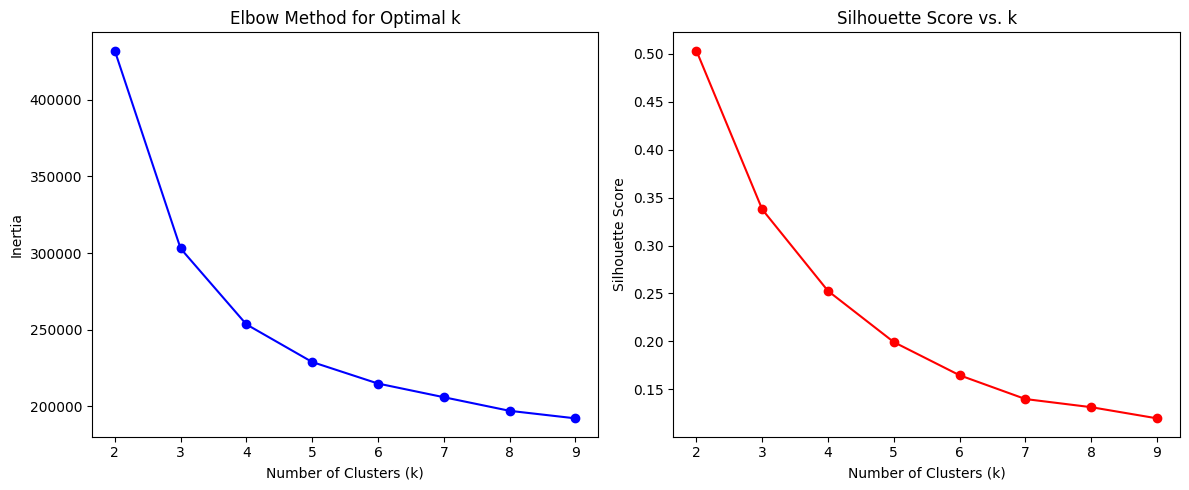

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib





# KMeans Clustering & Evaluation
elbow = []
silhouette_scores = []
K = range(2, 10)  # Try k = 2 to 9

for n_clusters in K:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_emb_train_reduced)

    # Store metrics
    elbow.append(clusterer.inertia_)  # Inertia for elbow method
    silhouette_avg = silhouette_score(X_emb_train_reduced, cluster_labels)
    silhouette_scores.append(silhouette_avg)

    print(f"n_clusters = {n_clusters}, Silhouette Score = {silhouette_avg:.4f}, Inertia = {clusterer.inertia_:.2f}")

#  Plot Elbow Method & Silhouette Scores
plt.figure(figsize=(12,5))

# Elbow Plot
plt.subplot(1,2,1)
plt.plot(K, elbow, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

# Silhouette Plot
plt.subplot(1,2,2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. k')

plt.tight_layout()
plt.show()


# Choose final k (based on plots or manually)
#optimal_k = 2  # You can change this after inspecting the plots

#final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
#final_labels = final_kmeans.fit_predict(X_emb_train_reduced)

# Visualize clusters in 2D (optional)
#pca_2d = PCA(n_components=2, random_state=42)
#X_2d = pca_2d.fit_transform(X_emb_train_reduced)

#plt.figure(figsize=(7,6))
#plt.scatter(X_2d[:,0], X_2d[:,1], c=final_labels, cmap='viridis', s=15)
#plt.title(f'KMeans Clusters Visualization (k={optimal_k})')
#plt.xlabel('PCA Component 1')
#plt.ylabel('PCA Component 2')
#plt.show()



## Merge TF-IDF + RoBERTa embeddings + metadata

In [17]:
# TF-IDF is sparse, embeddings and meta are dense, so we convert meta & embeddings to sparse

X_train_final = hstack([X_tfidf_train, csr_matrix(X_emb_train_reduced), csr_matrix(X_meta_train)])
X_val_final   = hstack([X_tfidf_val, csr_matrix(X_emb_val_reduced), csr_matrix(X_meta_val)])
X_test_final  = hstack([X_tfidf_test, csr_matrix(X_emb_test_reduced), csr_matrix(X_meta_test)])

print("Train final shape:", X_train_final.shape)
print("Validation final shape:", X_val_final.shape)
print("Test final shape:", X_test_final.shape)

Train final shape: (160718, 50105)
Validation final shape: (34440, 50105)
Test final shape: (34440, 50105)


## Train Hybrid (TF-IDF + RoBERTa embeddings + metadata) Model

In [18]:
# Define models
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, n_jobs=-1),
    "RandomForest": RandomForestClassifier(
            n_estimators=200, max_depth=15, n_jobs=-1, random_state=42
        ),
    "LightGBM": lgb.LGBMClassifier(
        n_estimators=200, max_depth=10, n_jobs=-1, random_state=42
    )
}

#store metrics
metrics_df = pd.DataFrame(columns=[
    "Model", "Dataset", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC", "Confusion_Matrix", "Train_Time"
])

# Train and evaluate
for name, model in models.items():
    print(f"\nTraining {name}...")

    start_time = time.time()
    model.fit(X_train_final, y_train)
    train_time = time.time() - start_time

    # Training metrics
    y_train_pred = model.predict(X_train_final)
    y_train_prob = model.predict_proba(X_train_final)[:,1]

    train_row = pd.DataFrame([{
        "Model": name,
        "Dataset": "Train",
        "Accuracy": accuracy_score(y_train, y_train_pred),
        "Precision": precision_score(y_train, y_train_pred),
        "Recall": recall_score(y_train, y_train_pred),
        "F1": f1_score(y_train, y_train_pred),
        "ROC_AUC": roc_auc_score(y_train, y_train_prob),
        "Confusion_Matrix": confusion_matrix(y_train, y_train_pred),
        "Train_Time": train_time
    }])
    metrics_df = pd.concat([metrics_df, train_row], ignore_index=True)

    # Validation metrics
    y_val_pred = model.predict(X_val_final)
    y_val_prob = model.predict_proba(X_val_final)[:,1]

    val_row = pd.DataFrame([{
        "Model": name,
        "Dataset": "Validation",
        "Accuracy": accuracy_score(y_val, y_val_pred),
        "Precision": precision_score(y_val, y_val_pred),
        "Recall": recall_score(y_val, y_val_pred),
        "F1": f1_score(y_val, y_val_pred),
        "ROC_AUC": roc_auc_score(y_val, y_val_prob),
        "Confusion_Matrix": confusion_matrix(y_val, y_val_pred),
        "Train_Time": train_time
    }])
    metrics_df = pd.concat([metrics_df, val_row], ignore_index=True)

#best model by highest val F1
val_metrics = metrics_df[metrics_df['Dataset']=="Validation"]
best_model_name = val_metrics.loc[val_metrics['F1'].idxmax(), "Model"]
best_model = models[best_model_name]

print(f"\nBest model based on Validation F1: {best_model_name}")

# Save the best model
joblib.dump(best_model, "best_hybrid_model.pkl")
print("Best model saved to", f"best_hybrid_model.pkl")

# Save metrics DataFrame
metrics_df.to_csv("model_metrics1.csv", index=False)
print("Metrics saved")

# Display metrics
metrics_df



Training LogisticRegression...

Training RandomForest...

Training LightGBM...


C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\PC\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Best model based on Validation F1: LogisticRegression
Best model saved to best_hybrid_model.pkl
Metrics saved


,Model,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,Confusion_Matrix,Train_Time
0,LogisticRegression,Train,0.966631,0.972264,0.960367,0.966279,0.994768,"[[78517, 2192], [3171, 76838]]",37.901263
1,LogisticRegression,Validation,0.959175,0.965348,0.952173,0.958715,0.992300,"[[16709, 586], [820, 16325]]",37.901263
2,RandomForest,Train,0.858273,0.950574,0.754540,0.841288,0.956259,"[[77570, 3139], [19639, 60370]]",38.020915
3,RandomForest,Validation,0.853659,0.941434,0.752873,0.836661,0.951880,"[[16492, 803], [4237, 12908]]",38.020915
4,LightGBM,Train,0.955444,0.965280,0.944469,0.954761,0.992497,"[[77991, 2718], [4443, 75566]]",439.615728
5,LightGBM,Validation,0.945993,0.955372,0.935200,0.945178,0.988376,"[[16546, 749], [1111, 16034]]",439.615728


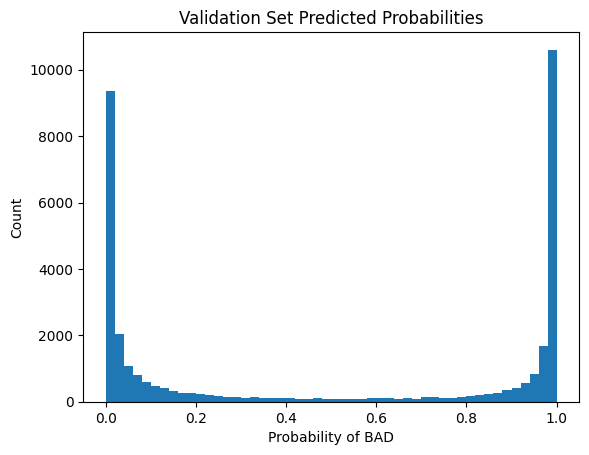

In [19]:
# View Predicted Probabilities Distribution
best_model = joblib.load("best_hybrid_model.pkl")

# Predicted probabilities on validation set
probs = best_model.predict_proba(X_val_final)[:, 1]

# Plot histogram
plt.hist(probs, bins=50)
plt.title("Validation Set Predicted Probabilities")
plt.xlabel("Probability of BAD")
plt.ylabel("Count")
plt.show()


The Logistic Regression model produced predicted probabilities that are mostly concentrated near 0 and 1. This indicates that the hybrid features (TF-IDF, RoBERTa embeddings, and metadata) provide a clear separation between legitimate and phishing URLs. Logistic Regression, which normally spreads probabilities across a smoother range, is confident here because the features strongly distinguish the two classes. This confidence also reduces the benefit of threshold tuning, since most predictions are already decisively classified.

In [20]:
# Use the best model you saved after training
coefs = best_model.coef_[0]   # since Logistic Regression was best

# Collect feature names
tfidf_features = vectorizer.get_feature_names_out()
pca_features   = [f"pca_{i}" for i in range(X_emb_train_reduced.shape[1])]
meta_features  = ['has_at', 'dash_in_domain', 'url_redirection',
                  'sensitive_words', 'many_slashes']

all_features = np.concatenate([tfidf_features, pca_features, meta_features])

# Build DataFrame of feature importance
feat_importance = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": coefs,
    "Abs_Coefficient": np.abs(coefs)
}).sort_values(by="Abs_Coefficient", ascending=False)

# Show top 20 features
feat_importance.head(20)


,Feature,Coefficient,Abs_Coefficient
50009,pca_9,5.968224,5.968224
50081,pca_81,-5.858434,5.858434
50006,pca_6,5.371293,5.371293
43911,sp,-4.983344,4.983344
50008,pca_8,4.496898,4.496898
50036,pca_36,4.488773,4.488773
4870,/en,-4.148795,4.148795
50001,pca_1,-4.100135,4.100135
3020,.asp,-4.009812,4.009812
26779,htm,-3.945239,3.945239


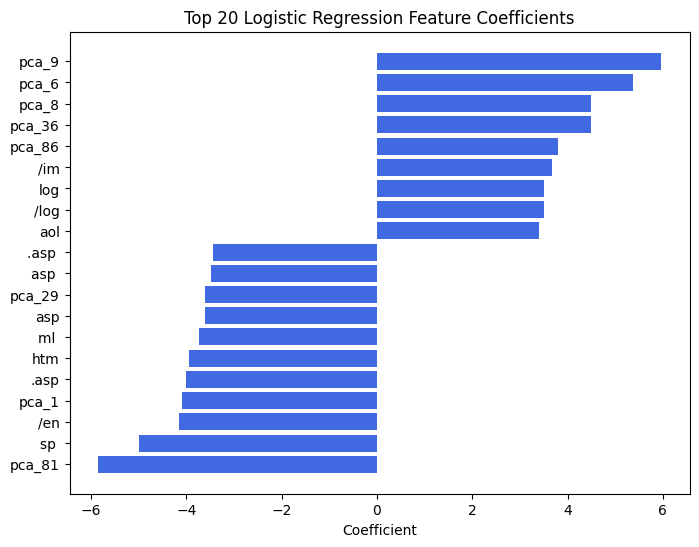

In [21]:
plt.figure(figsize=(8,6))
top_feats = feat_importance.head(20).sort_values("Coefficient")
plt.barh(top_feats["Feature"], top_feats["Coefficient"], color="royalblue")
plt.title("Top 20 Logistic Regression Feature Coefficients")
plt.xlabel("Coefficient")
plt.show()


The hybrid model learns most of its discriminatory power from semantic embeddings (PCA-reduced RoBERTa features), but certain character n-grams remain strong indicators. Old file extensions (.asp, .htm, .ml) and login-related substrings (/log, /en) strongly influence classification. This highlights that attackers often rely on predictable string patterns, but contextual embeddings give the model deeper generalization ability.

## Best Hybrid Model

Classification Report for LogisticRegression on Test Set:

              precision    recall  f1-score   support

    Good (0)       0.96      0.96      0.96     17295
     Bad (1)       0.96      0.96      0.96     17145

    accuracy                           0.96     34440
   macro avg       0.96      0.96      0.96     34440
weighted avg       0.96      0.96      0.96     34440

Confusion Matrix:
[[16687   608]
 [  753 16392]]
 


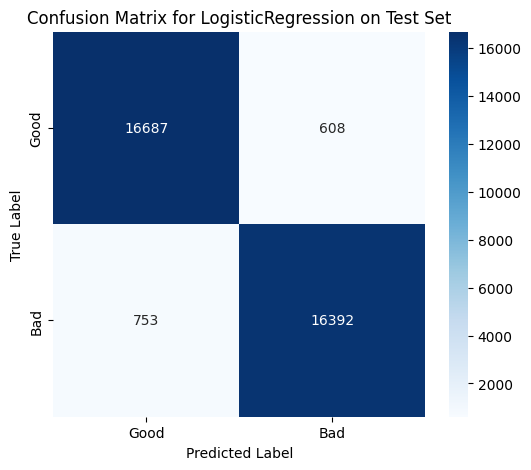

In [22]:
# Predict on test set
y_test_pred = best_model.predict(X_test_final)
y_test_prob = best_model.predict_proba(X_test_final)[:, 1]

# Classification report
print(f"Classification Report for {best_model_name} on Test Set:\n")
print(classification_report(y_test, y_test_pred, target_names=['Good (0)', 'Bad (1)']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print(f"Confusion Matrix:\n{cm}")

# Optional: store metrics in metrics_df
best_df = pd.concat([metrics_df, pd.DataFrame([{
    "Model": best_model_name,
    "Dataset": "Test",
    "Accuracy": accuracy_score(y_test, y_test_pred),
    "Precision": precision_score(y_test, y_test_pred),
    "Recall": recall_score(y_test, y_test_pred),
    "F1": f1_score(y_test, y_test_pred),
    "ROC_AUC": roc_auc_score(y_test, y_test_prob),
    "Confusion_Matrix": cm,
    "Train_Time": None
}])], ignore_index=True)
best_df.to_csv(f"{best_model_name}_model_test_metrics.csv", index=False)

print(" ")

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Good','Bad'], yticklabels=['Good','Bad'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name} on Test Set')
plt.show()


## Compare

In [23]:
all_metrics = pd.concat(
    [hmetrics_df.assign(Feature_Set="Heuristic-only"),
     tmetrics_df.assign(Feature_Set="TF-IDF-only"),
     metrics_df.assign(Feature_Set="Hybrid")],
    ignore_index=True
)

# Save to CSV for reporting
all_metrics.to_csv("all_model_metrics.csv", index=False)

# Preview
all_metrics


,Model,Dataset,Accuracy,Precision,Recall,F1,ROC_AUC,Confusion_Matrix,Train_Time,Feature_Set
0,LogisticRegression,Train,0.648832,0.838280,0.365009,0.508572,0.655744,"[[75075, 5634], [50805, 29204]]",11.030905,Heuristic-only
1,LogisticRegression,Validation,0.647184,0.834988,0.363021,0.506037,0.654202,"[[16065, 1230], [10921, 6224]]",11.030905,Heuristic-only
2,RandomForest,Train,0.648832,0.838280,0.365009,0.508572,0.655769,"[[75075, 5634], [50805, 29204]]",5.060355,Heuristic-only
3,RandomForest,Validation,0.647184,0.834988,0.363021,0.506037,0.654221,"[[16065, 1230], [10921, 6224]]",5.060355,Heuristic-only
4,LightGBM,Train,0.648832,0.838280,0.365009,0.508572,0.655769,"[[75075, 5634], [50805, 29204]]",0.863252,Heuristic-only
5,LightGBM,Validation,0.647184,0.834988,0.363021,0.506037,0.654221,"[[16065, 1230], [10921, 6224]]",0.863252,Heuristic-only
6,LogisticRegression,Train,0.955064,0.964517,0.944481,0.954394,0.991575,"[[77929, 2780], [4442, 75567]]",10.382411,TF-IDF-only
7,LogisticRegression,Validation,0.950668,0.961957,0.937999,0.949827,0.989563,"[[16659, 636], [1063, 16082]]",10.382411,TF-IDF-only
8,RandomForest,Train,0.826429,0.931335,0.703183,0.801336,0.931133,"[[76561, 4148], [23748, 56261]]",29.523533,TF-IDF-only
9,RandomForest,Validation,0.822677,0.923951,0.701546,0.797533,0.927714,"[[16305, 990], [5117, 12028]]",29.523533,TF-IDF-only


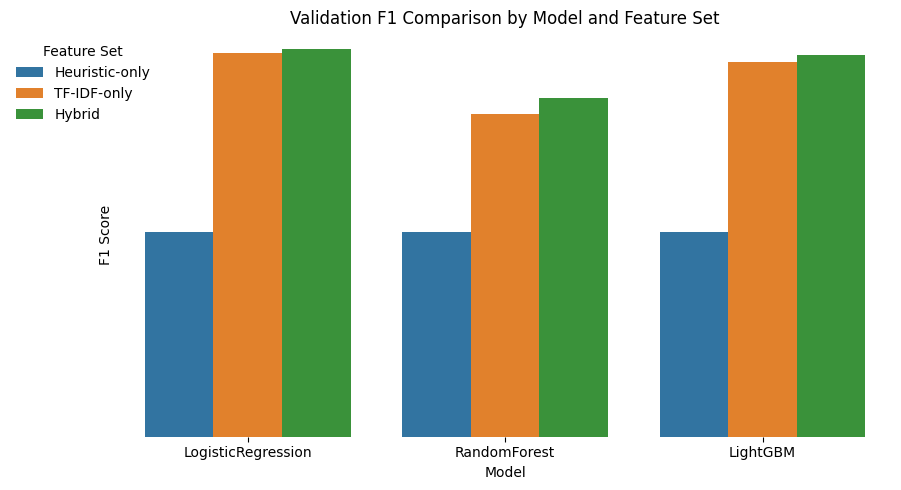

In [24]:
# Filter only validation set
val_metrics = all_metrics[all_metrics['Dataset'] == "Validation"].copy()

plt.figure(figsize=(9,5))
sns.barplot(
    data=val_metrics,
    x='Model',
    y='F1',
    hue='Feature_Set'
)

plt.title("Validation F1 Comparison by Model and Feature Set")
plt.ylim(0, 1)
plt.yticks([])
plt.xlabel("Model")
plt.ylabel("F1 Score")
# Remove box around plot
sns.despine(left=True, bottom=True)

#  legend
plt.legend(
    title='Feature Set',
    loc='upper left',
    bbox_to_anchor=(-0.15, 1),
    frameon=False
)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The heuristic-only model performed poorly with an F1 of about 0.50.

Using TF-IDF features greatly improved performance, with Logistic Regression reaching an F1 of about 0.95.

The hybrid feature set (TF-IDF + embeddings + heuristics) achieved the best results, with Logistic Regression reaching an F1 of about 0.96 and strong recall.

Across all feature sets, Logistic Regression consistently outperformed Random Forest and LightGBM while also being faster to train.

## Infer via Streamlit

In [25]:
!pip install -q streamlit -U pyngrok
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)

import streamlit as st
from pyngrok import ngrok
import os
import threading

ngrok.set_auth_token("33W68MHPPuOVyk0srRyIc8OUpOv_2xj2HxAgYq43seitPmqwb")

In [26]:
with open("app.py", "w") as f:
    f.write("""
import streamlit as st
import joblib, torch, re, numpy as np
from urllib.parse import urlparse
import tldextract
from transformers import AutoTokenizer, AutoModel

st.title("🔍 URL Phishing Detector")

# Load artifacts
tfidf_path = "/content/drive/MyDrive/Colab Notebooks/Paul/tfidf_vectorizer.pkl"
pca_path   = "/content/drive/MyDrive/Colab Notebooks/Paul/pca_roberta.pkl"
model_path = "/content/drive/MyDrive/Colab Notebooks/Paul/best_hybrid_model.pkl"

vectorizer = joblib.load(tfidf_path)
pca        = joblib.load(pca_path)
clf        = joblib.load(model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
roberta_model = AutoModel.from_pretrained("distilroberta-base").to(device)
roberta_model.eval()

# Helper functions
SENSITIVE_WORDS = [
    'confirm','account','banking','secure','ebyisapi','webscr','signin',
    'mail','install','toolbar','backup','paypal','password','username'
]

def clean_url(url: str) -> str:
    url = url.lower().strip()
    url = re.sub(r'^https?://', '', url)
    url = re.sub(r'^www\.', '', url)
    url = re.sub(r'[\?#].*', '', url)
    url = url.rstrip('/')
    return url

def get_meta_features(url: str):
    parsed = urlparse(url)
    ext = tldextract.extract(url)
    return np.array([
        int('@' in url),
        int('-' in ext.domain),
        int('//' in (parsed.path or '')),
        int(any(word in url for word in SENSITIVE_WORDS)),
        int(url.count('/') > 5)
    ], dtype=int)

def get_roberta_embedding(url: str):
    with torch.no_grad():
        encoded = tokenizer([url], padding=True, truncation=True, return_tensors="pt").to(device)
        outputs = roberta_model(**encoded)
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
    return emb

def predict_url(url: str):
    url_clean = clean_url(url)
    meta_feat = get_meta_features(url_clean).reshape(1, -1)
    tfidf_feat = vectorizer.transform([url_clean])
    emb_feat = get_roberta_embedding(url_clean)
    emb_feat_reduced = pca.transform(emb_feat)
    final_feat = np.hstack([tfidf_feat.toarray(), emb_feat_reduced, meta_feat])

    pred_label = clf.predict(final_feat)[0]
    pred_prob  = clf.predict_proba(final_feat)[0, 1]
    label_str = "BAD (Phishing URL)" if pred_label==1 else "GOOD (Legit URL)"
    return label_str, pred_prob

#  Streamlit UI
# Initialize session state for text area
if "url_text" not in st.session_state:
    st.session_state.url_text = ""

def clear_text():
    st.session_state.url_text = ""  # this works as a callback

# Text area
url_input = st.text_area("Enter URL(s) separated by commas:", value=st.session_state.url_text, key="url_text")

# Buttons in two columns
col1, col2, col3 = st.columns([2, 5, 1])

with col1:
    check_btn = st.button("Check URL")
with col3:
    clear_btn = st.button("Clear", on_click=clear_text)

# Check URLs logic
if check_btn and url_input.strip():
    url_list = [u.strip() for u in url_input.split(",") if u.strip()]
    for url in url_list:
        try:
            label, prob = predict_url(url)
            if label.startswith("BAD"):
                st.error(f"⚠️ Warning: {url} is likely a phishing site! Probability: {prob*100:.0f}%")
            else:
                st.success(f"✅ Safe: {url} appears legitimate! Probability: {prob*100:.0f}%")
        except Exception as e:
            st.warning(f"⚠️ {url} → Error: {e}")
""")

In [27]:
# Kill all tunnels
ngrok.kill()

In [28]:
# Start Streamlit
def run_streamlit():
    os.system("streamlit run app.py")

threading.Thread(target=run_streamlit, daemon=True).start()

# ngrok tunnel via HTTP
public_url = ngrok.connect(addr=8501, proto="http")
print("Streamlit URL:", public_url)

Streamlit URL: NgrokTunnel: "https://genealogic-gemmily-lissa.ngrok-free.dev" -> "http://localhost:8501"
